# `Buisness Dataset`

In [1]:
# Import libraries

import pandas as pd
import numpy as np
from collections import defaultdict

# pip install google-cloud-storage       ## Run only if you want to install dependency
from google.cloud import storage

In [2]:
## Run this block only once to download files from Google cloud to VM instance


""" Reference: 
https://stackoverflow.com/questions/56721927/how-to-load-data-to-jupyter-notebook-vm-from-google-cloud
"""


bucket_name = "springboard-yelp"

storage_client = storage.Client()
bucket = storage_client.get_bucket(bucket_name)

blobs = bucket.list_blobs()

# When you have your files on the first level of your bucket
for blob in blobs:
    file_name = blob.name
    blob.download_to_filename(file_name) # download the file to the machine 

In [3]:
# Load data

business_data = pd.read_json('business.json', lines=True)
business = pd.DataFrame(business_data)

In [4]:
# Get useful information about dataframe

business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209393 entries, 0 to 209392
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   209393 non-null  object 
 1   name          209393 non-null  object 
 2   address       209393 non-null  object 
 3   city          209393 non-null  object 
 4   state         209393 non-null  object 
 5   postal_code   209393 non-null  object 
 6   latitude      209393 non-null  float64
 7   longitude     209393 non-null  float64
 8   stars         209393 non-null  float64
 9   review_count  209393 non-null  int64  
 10  is_open       209393 non-null  int64  
 11  attributes    180348 non-null  object 
 12  categories    208869 non-null  object 
 13  hours         164550 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 22.4+ MB


In [5]:
# Get 'states' information

business.state.unique()

array(['NC', 'AZ', 'QC', 'NV', 'IL', 'ON', 'AB', 'PA', 'WI', 'SC', 'OH',
       'CA', 'TX', 'NY', 'CO', 'XWY', 'GA', 'BC', 'YT', 'HPL', 'AL', 'UT',
       'VT', 'WA', 'NE', 'DOW', 'MI', 'FL', 'AR', 'HI', 'MB', 'OR', 'AK',
       'VA', 'CT', 'MO', 'DUR'], dtype=object)

In [6]:
# Consider only US states

us_states = ['AL','AK','AR','AS','AZ','CA','CO','CT','DC','DE','FL','FM','GA','GU','HI','IA','ID','IL','IN','KS','KY','LA','MA','MD','ME','MH','MI','MN','MO','MS','MT','NC','ND','NE','NH','NJ','NM','NV','NY','MP','OH','OK','OR','PA','PR','PW','RI','SC','SD','TN','TX','UT','VA','VI','VT','WA','WI','WV','WY']

In [7]:
# Clean data by removing null 

business = business[business.categories.notnull()]
len(business)

208869

In [8]:
# Extract categories

category = defaultdict(int)

for idx, row in business.iterrows():
    if row['categories'] is not np.nan: 
        data = row['categories'].split(',')
        for entry in data: 
            entry = entry.strip().lower()
            category[entry] += 1

In [9]:
category_sorted = sorted(category.items(), key=lambda x: x[1], reverse=True)
print(len(category))
print(category_sorted[:20])

1336
[('restaurants', 63944), ('shopping', 34644), ('food', 32991), ('home services', 22487), ('beauty & spas', 20520), ('health & medical', 19227), ('local services', 15783), ('automotive', 14720), ('nightlife', 14211), ('bars', 12400), ('event planning & services', 11263), ('active life', 10225), ('coffee & tea', 8415), ('fashion', 8374), ('fast food', 8106), ('sandwiches', 8064), ('american (traditional)', 7596), ('home & garden', 7331), ('hair salons', 7303), ('pizza', 7302)]


In [10]:
# Apply filters for states and categories
# Reduced to 153579 by 26% after US states and then restaurant related to 44202 reduced by 78% overall based on non- null data

business = business[(business.postal_code.astype(str).apply(len) == 5) & (business.state.isin(us_states)) & 
                    ((business.categories.str.contains('restaurant', case=False)) |
                     (business.categories.str.contains('bar', case=False)) | 
                     (business.categories.str.contains('nightlife', case=False)))]

In [11]:
# Confirm data contains only US states

business.state.unique()

array(['IL', 'NC', 'AZ', 'NV', 'OH', 'PA', 'SC', 'WI', 'TX', 'CO', 'NY',
       'FL', 'VT', 'AR', 'HI', 'OR', 'WA', 'AK', 'CA', 'VA', 'NE'],
      dtype=object)

<AxesSubplot:>

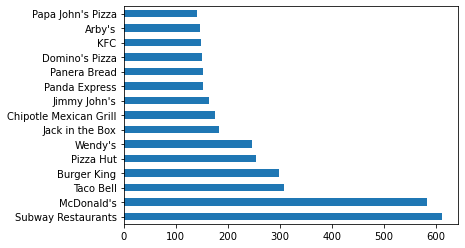

In [12]:
# Plot frequent places

business.name.value_counts()[:15].plot(kind='barh')

In [13]:
# Extract cuisine and style from 'categories' column information 

cuisines = ['american (new)', 'american (traditional)', 'asian fusion', 'bagels', 'bakeries', 
            'barbeque', 'beer', 'bubble tea', 'burgers', 'cajun', 'chicken wings', 'chinese', 
            'coffee & tea', 'cupcakes', 'custom cakes', 'desserts', 'donuts', 'ethnic food', 
            'french', 'gluten-free', 'greek', 'hawaiian', 'hot dogs', 'ice cream & frozen yogurt', 
            'indian', 'italian', 'japanese', 'korean', 'latin american', 'local flavor', 'mediterranean', 
            'mexican', 'middle eastern', 'pizza', 'salad', 'sandwiches', 'seafood', 'shaved ice', 'soup', 
            'southern', 'specialty food', 'steakhouse', 'sushi bars', 'tacos', 'tapas/small plates', 'tex-mex', 
            'thai', 'vegan', 'vegetarian', 'vietnamese', 'wine & spirits']

styles = ['bars', 'beer bars', 'breakfast & brunch', 'breweries', 'buffets', 'cafes', 'casinos', 
          'caterers', 'cocktail bars', 'dance clubs', 'delis', 'diners', 'dive bars', 'fast food', 
          'food delivery services', 'food stands', 'food trucks', 'juice bars & smoothies', 'lounges', 
          'music venues', 'nightlife', 'performing arts', 'pubs', 'restaurants', 'sports bars', 'street vendors', 
          'wine bars']

# Create new columns
business['cuisine'] = None
business['style'] = None


for idx, row in business.iterrows():
    if row['categories'] is not np.nan:
        cuisine_list = row['categories'].split(',')
        #print(cuisine_list)
        for i in cuisine_list:
            i = i.strip().lower()
            # print(i)
            if i in cuisines:
                # print('cuisine')
                if business.loc[idx, 'cuisine'] == None:
                    business.loc[idx, 'cuisine'] = i
                else:
                    business.loc[idx, 'cuisine'] += (',' + i)
                #print(business['cuisine'])
                
            elif i in styles:
                # print('style')
                if business.loc[idx, 'style'] == None:
                    business.loc[idx, 'style'] = i
                else:
                    business.loc[idx, 'style'] += (',' + i)
                #print(business['style'])

In [14]:
# Update None with NaN
# Reset index
# check NaN

business.fillna(value=np.nan, inplace=True)
business.reset_index(drop=True, inplace=True)
business.isnull().sum()

business_id        0
name               0
address            0
city               0
state              0
postal_code        0
latitude           0
longitude          0
stars              0
review_count       0
is_open            0
attributes       732
categories         0
hours           8517
cuisine         7946
style           1930
dtype: int64

In [15]:
business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44202 entries, 0 to 44201
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   44202 non-null  object 
 1   name          44202 non-null  object 
 2   address       44202 non-null  object 
 3   city          44202 non-null  object 
 4   state         44202 non-null  object 
 5   postal_code   44202 non-null  object 
 6   latitude      44202 non-null  float64
 7   longitude     44202 non-null  float64
 8   stars         44202 non-null  float64
 9   review_count  44202 non-null  int64  
 10  is_open       44202 non-null  int64  
 11  attributes    43470 non-null  object 
 12  categories    44202 non-null  object 
 13  hours         35685 non-null  object 
 14  cuisine       36256 non-null  object 
 15  style         42272 non-null  object 
dtypes: float64(3), int64(2), object(11)
memory usage: 5.4+ MB


## Summary of 'business dataframe'

1. `business_id`: No NaN, 22 character length, case-sensitive corresponds to `business_id` in user dataframe
2. `name`, `address`, `city`, `state`, `postal_code`, `latitude`, `longitude`, `review_count`: No NaN
3. `stars`: No NaN, ratings take value 1(1%), 1.5(2.5%), 2(6%), 2.5(10%), 3(16.5%), 3.5(22%), 4(24%), 4.5(14%), 5(4%)
5. `is_open`: No NaN, 0 for closed(31%), 1 for open(69%)
6. `attributes`: 1.6% NaN with subattributes in nested dict
7. `categories`: No NaN, describes cusine or style
8. `hours`: 20% NaN
9. `cuisine`: 18% NaN, represents cuisines
10. `style`: 5% NaN, represents styles

# `Checkin Dataset`

In [16]:
# Load data

checkin_data = pd.read_json('checkin.json', lines=True)
checkin = pd.DataFrame(checkin_data)

In [17]:
# Get useful information about dataframe

checkin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175187 entries, 0 to 175186
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   business_id  175187 non-null  object
 1   date         175187 non-null  object
dtypes: object(2)
memory usage: 2.7+ MB


In [18]:
# Convert date column to string and count checkins

checkin['checkin_count'] = checkin['date'].astype(str).str.len()

In [19]:
checkin.head()

,business_id,date,checkin_count
0,--1UhMGODdWsrMastO9DZw,"2016-04-26 19:49:16, 2016-08-30 18:36:57, 2016...",145
1,--6MefnULPED_I942VcFNA,"2011-06-04 18:22:23, 2011-07-23 23:51:33, 2012...",3967
2,--7zmmkVg-IMGaXbuVd0SQ,"2014-12-29 19:25:50, 2015-01-17 01:49:14, 2015...",4051
3,--8LPVSo5i0Oo61X01sV9A,2016-07-08 16:43:30,19
4,--9QQLMTbFzLJ_oT-ON3Xw,"2010-06-26 17:39:07, 2010-08-01 20:06:21, 2010...",796


In [20]:
# Check NaN

checkin.isnull().sum()

business_id      0
date             0
checkin_count    0
dtype: int64

In [21]:
# Check duplicates

len(checkin['business_id'].unique())

175187

## Summary of 'business dataframe'

1. `business_id`: No NaN, unique ids, 22 characters
2. `date`: No NaN, nested dictionaries representing checkins
3. `checkin_count`: No NaN, total number of checkins ranging from 19 to 3185089

# `Review Dataset`

In [22]:
# Load data

review_data = pd.read_json('review.json', lines=True)
review = pd.DataFrame(review_data)

In [23]:
# Get useful information about dataframe

review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8021122 entries, 0 to 8021121
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   review_id    object        
 1   user_id      object        
 2   business_id  object        
 3   stars        int64         
 4   useful       int64         
 5   funny        int64         
 6   cool         int64         
 7   text         object        
 8   date         datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 550.8+ MB


In [24]:
# Convert text column to string

review['text'] = review['text'].astype(str)

In [25]:
# Replace -ve value 

review.loc[6543215, ['cool', 'useful']] = 0

In [27]:
# Check NaN

review.isnull().sum()

review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64

In [30]:
# Check duplicates

len(review['review_id'].unique())

8021122

## Summary of 'review dataframe'

1. `review_id`, `user_id`, `business_id`: No NaN, case sensitive, 22 characters
2. `stars`: No NaN, star rating from 1 to 5
3. `useful`: No NaN, useful votes for review from 0 to 1122
4. `funny`: No NaN, funny votes for review from 0 to 976
5. `cool`: No NaN, cool votes for review from o to 502
6. `text`: No NaN, actual reviews strings
7. `date`: No NaN, review date from 10/12/2004 to 12/13/2019

# `Tip Dataset`

In [37]:
# Load data

tip_data = pd.read_json('tip.json', lines=True)
tip = pd.DataFrame(tip_data)
tip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320761 entries, 0 to 1320760
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   user_id           1320761 non-null  object        
 1   business_id       1320761 non-null  object        
 2   text              1320761 non-null  object        
 3   date              1320761 non-null  datetime64[ns]
 4   compliment_count  1320761 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 50.4+ MB


In [40]:
# Check NaN 

tip.isnull().sum()

user_id             0
business_id         0
text                0
date                0
compliment_count    0
dtype: int64

## Summary of 'tip dataframe'

1. `user_id`: No NaN, 22 character length, case-sensitive corresponds to user_id in user dataframe
2. `business_id`: No NaN, 22 character length, case-sensitive corresponds to business_id in user dataframe
3. `text`: No NaN, string, text of the tip
4. `date`: No NaN, date ranges from 2009-04-16 to 2019-12-13 in YYYY-MM-DD format
5. `compliment_counts`: Number of likes tip received from 0 to 15

# `User Dataset`

In [41]:
# Load data

user_data = pd.read_json('user.json', lines=True)
user = pd.DataFrame(user_data)

In [44]:
# Get useful information from dataframe

user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1968703 entries, 0 to 1968702
Data columns (total 22 columns):
 #   Column              Dtype  
---  ------              -----  
 0   user_id             object 
 1   name                object 
 2   review_count        int64  
 3   yelping_since       object 
 4   useful              int64  
 5   funny               int64  
 6   cool                int64  
 7   elite               object 
 8   friends             object 
 9   fans                int64  
 10  average_stars       float64
 11  compliment_hot      int64  
 12  compliment_more     int64  
 13  compliment_profile  int64  
 14  compliment_cute     int64  
 15  compliment_list     int64  
 16  compliment_note     int64  
 17  compliment_plain    int64  
 18  compliment_cool     int64  
 19  compliment_funny    int64  
 20  compliment_writer   int64  
 21  compliment_photos   int64  
dtypes: float64(1), int64(16), object(5)
memory usage: 330.4+ MB


In [45]:
# Check NaN 

user.isnull().sum()

user_id               0
name                  0
review_count          0
yelping_since         0
useful                0
funny                 0
cool                  0
elite                 0
friends               0
fans                  0
average_stars         0
compliment_hot        0
compliment_more       0
compliment_profile    0
compliment_cute       0
compliment_list       0
compliment_note       0
compliment_plain      0
compliment_cool       0
compliment_funny      0
compliment_writer     0
compliment_photos     0
dtype: int64

## Summary of 'user dataframe'

1. `user_id`: No NaN, unique 22 characters
2. `name`: No NaN, name of the user
3. `review_count`: No NaN, total reviews of user fro 0 to 14455
4. `yelping_since`: No NaN, the date user joined Yelp from 10/12/2004 to 12/13/2019
5. `elite`: No NaN, conatins list of year member was elite (very active contributor)

## Convert to CSV

In [133]:
business.to_csv(path_or_buf='review.csv',index=False)
checkin.to_csv(path_or_buf='review.csv',index=False)
review.to_csv(path_or_buf='review.csv',index=False)
tip.to_csv(path_or_buf='review.csv',index=False)
user.to_csv(path_or_buf='review.csv',index=False)